# ONNX Inference

Using the best model developed with the train and valid datasets, I will now train it again and test against the final test dataset.

In addition, the performance will also be assessed after the model was converted to ONNX format.

Using features
['total_all_locations_per_hour', 'bathroom_proportion']

~~~~~~~~~~
Implementation: ONNX
unseen AUC ROC: 0.612276154829087

~~~~~~~~~~
Implementation: SKlearn
unseen AUC ROC: 0.612276154829087


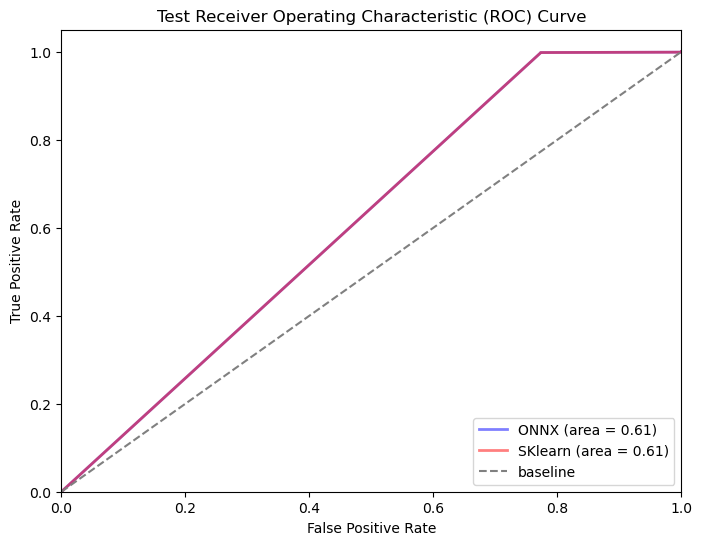

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from onnxruntime import InferenceSession
from skl2onnx import to_onnx
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from lib.common.paths import DATABASE_LOCATION
from lib.data.features import add_all_features, read_raw_data
from lib.model.fit import post_warmup_locator, rebalance_classes

response = "multiple_occupancy"
multi_location_windows = []

df_train = add_all_features(read_raw_data(DATABASE_LOCATION, train=True, valid=True), multi_location_windows)
# oversample under-represented class to balance training data
df_train = rebalance_classes(df_train, response)
df_test = add_all_features(read_raw_data(DATABASE_LOCATION, test=True), multi_location_windows)

total_features = ["total_all_locations_per_hour", "bathroom_proportion"]
print(f"Using features\n{total_features}")

# introduce warmup period
minimum_observations = 5
minimum_elapsed_time_hours = 1.0

train_locator = post_warmup_locator(df_train, minimum_observations, minimum_elapsed_time_hours)
X = df_train.loc[train_locator, total_features].values.astype(np.float64)
y = df_train.loc[train_locator, response].values.astype(np.float64)

test_locator = post_warmup_locator(df_test, minimum_observations, minimum_elapsed_time_hours)
X_test = df_test.loc[test_locator, total_features].values.astype(np.float64)
y_test = df_test.loc[test_locator, response].values.astype(np.float64)

_FP_R_TOL = 1e6

pipeline = Pipeline(
    [
        ("classifier", DecisionTreeClassifier(max_depth=2, min_samples_leaf=40000)),
    ]
)
pipeline.fit(X, y)

onx = to_onnx(pipeline, X[:1].astype(np.float32), target_opset=12)

sess = InferenceSession(onx.SerializeToString(), providers=["CPUExecutionProvider"])
pred_ort = pd.DataFrame(sess.run(None, {"X": X_test.astype(np.float32)})[1]).iloc[:, 1].values
pred_skl = pipeline.predict_proba(X_test.astype(np.float32))[:, 1]

assert np.all(np.isclose(pred_ort, pred_skl, rtol=_FP_R_TOL))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

cmap = {"ONNX": "blue", "SKlearn": "red"}

for source, y_pred in zip(["ONNX", "SKlearn"], [pred_ort, pred_skl]):
    print(f"\n{'~'*10}")
    print(f"Implementation: {source}")
    roc = roc_auc_score(y_test, y_pred)
    print(f"unseen AUC ROC: {roc}")

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, color=cmap[source], alpha=0.5, lw=2, label="%s (area = %0.2f)" % (source, roc))

ax.plot([0, 1], [0, 1], color="gray", linestyle="--", label="baseline")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Test Receiver Operating Characteristic (ROC) Curve")
ax.legend(loc="lower right")

## Conclusion

Model performance on the final unseen set has decined from 79 on the validation set to 61 on the test set. It may be worth investing again with a larger set of homes, as this could be partially attributed to there being so few unique homes in the test set, causing high variance in our measured model effectiveness and downstream model selection decisions.

In the below table, we can see that the model predictions were wrong in cases where there was a higher bathroom proportion for a single occupancy household than we had fit to in the training and test sets.

ONNX conversion of the decision tree resulted in the same predicted probabilities.

In [2]:
df_test.loc[test_locator, "pred_proba"] = pred_skl
    df_test.groupby("home_id").agg(
        {
            "multiple_occupancy": "first",
            "pred_proba": "last",
            "datetime": lambda x: len(set(x)),
            "bathroom_proportion": "last",
            "total_all_locations_per_hour": "last",
            "elapsed_time_hours": "last",
        }
    ).sort_values("multiple_occupancy", ascending=False)

,multiple_occupancy,pred_proba,datetime,bathroom_proportion,total_all_locations_per_hour,elapsed_time_hours
home_id,,,,,,
0f44ff9edd221e417195f4398d2f3853,1,0.709938,15266,0.039796,20.697949,739.348611
205c42ec747e2db13cb92087a99433f1,1,0.709938,16116,0.077945,21.782575,743.300556
5d551393aa8a77bfe52abbab052ff76e,1,0.709938,10590,0.075589,14.300134,741.951111
62c8145530aca30cb0455dc386c0a9d6,1,0.709938,14571,0.193597,19.709178,743.257778
6be9c116a8a5e94d01efe4b6ebb3a1fe,1,0.709938,13313,0.203955,18.453104,723.509722
c07573c70bf978b70906b09edcbc6d57,1,0.709938,16254,0.171969,21.960793,741.412222
16d71b9c46d9abd765bf395818efe527,0,0.709938,6771,0.228024,9.256082,732.491389
20a3ebd4470c712d6f6d99908d931e09,0,0.023951,7159,0.000000,9.672822,740.838611
2b5ce37a65e82735416d69b987d99fe8,0,0.709938,4510,0.178271,6.064695,743.648333
